# 데이콘 집값 예측 경진대회

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
train.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


In [4]:
print(train.shape)
print(test.shape)

(1350, 15)
(1350, 14)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1350 non-null   int64 
 1   Overall Qual    1350 non-null   int64 
 2   Gr Liv Area     1350 non-null   int64 
 3   Exter Qual      1350 non-null   object
 4   Garage Cars     1350 non-null   int64 
 5   Garage Area     1350 non-null   int64 
 6   Kitchen Qual    1350 non-null   object
 7   Total Bsmt SF   1350 non-null   int64 
 8   1st Flr SF      1350 non-null   int64 
 9   Bsmt Qual       1350 non-null   object
 10  Full Bath       1350 non-null   int64 
 11  Year Built      1350 non-null   int64 
 12  Year Remod/Add  1350 non-null   int64 
 13  Garage Yr Blt   1350 non-null   int64 
 14  target          1350 non-null   int64 
dtypes: int64(12), object(3)
memory usage: 158.3+ KB


# ▶︎ 타겟 변수 관찰
- 회귀문제에서는 타겟 변수의 분포도 유심히 살피는 것이 좋다
- 타겟 : 집값
- 이상치는 없는지, 정규분포와 유사한 모양을 따르는지 관찰!

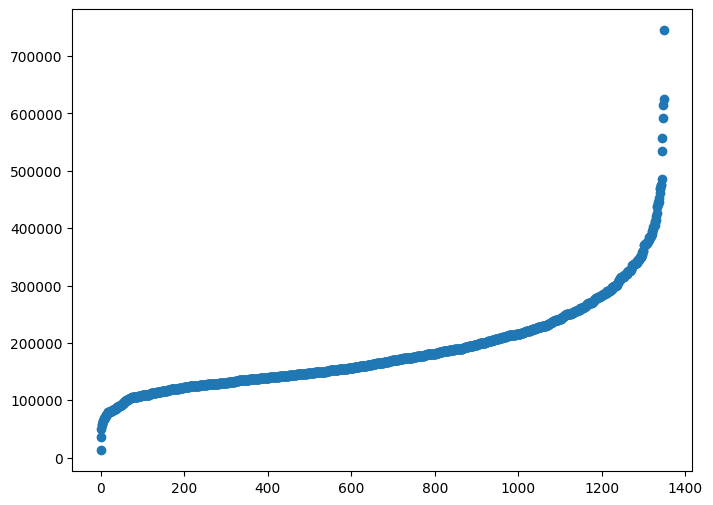

In [7]:
plt.figure(figsize = (8, 6))

# target인 집값을 크기 순으로 정렬하고, 그래프로 관찰
plt.scatter(range(train.shape[0]), np.sort(train['target'].values))
plt.show()

<Axes: xlabel='target', ylabel='Density'>

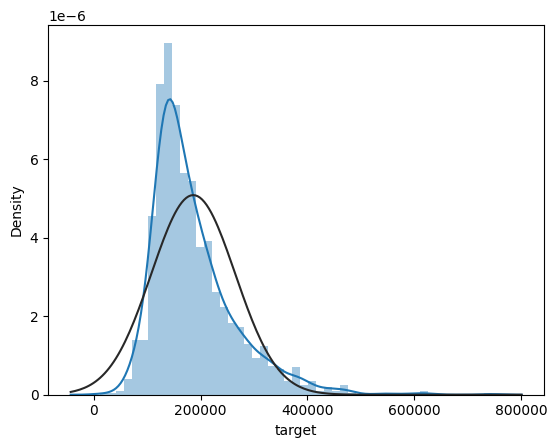

In [8]:
sns.distplot(train['target'], fit = stats.norm)

#### =>> target 변수의 정규성에 대해 살펴봄
- 오른쪽 꼬리가 길어서, 로그변환 검토!

<Axes: xlabel='target', ylabel='Density'>

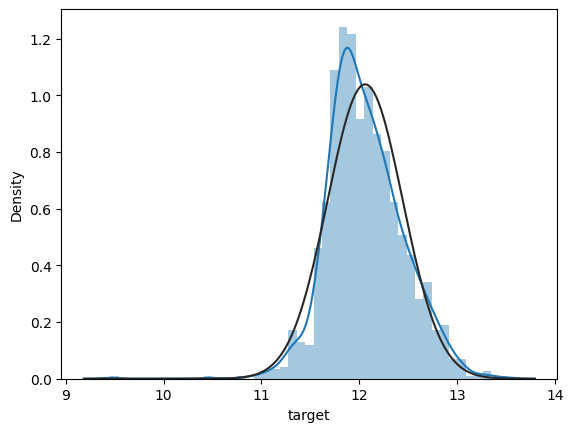

In [9]:
sns.distplot(np.log1p(train['target']), fit=stats.norm)

#### => 타겟 변수를 로그변환한 뒤, 정규성 확인

# ▶︎ 이산형 변수 관찰

# Overall Qual 변수
- 전반적 재료와 마감품질 변수

In [10]:
train['Overall Qual'].value_counts()

5     379
6     351
7     307
8     156
4      75
9      56
10     15
3       8
2       3
Name: Overall Qual, dtype: int64

#### => 변수가 2~ 10까지 있는데, 중앙값인 5, 6, 7에 몰려있음
- 개수 30개 이하 범주는 병합 고려

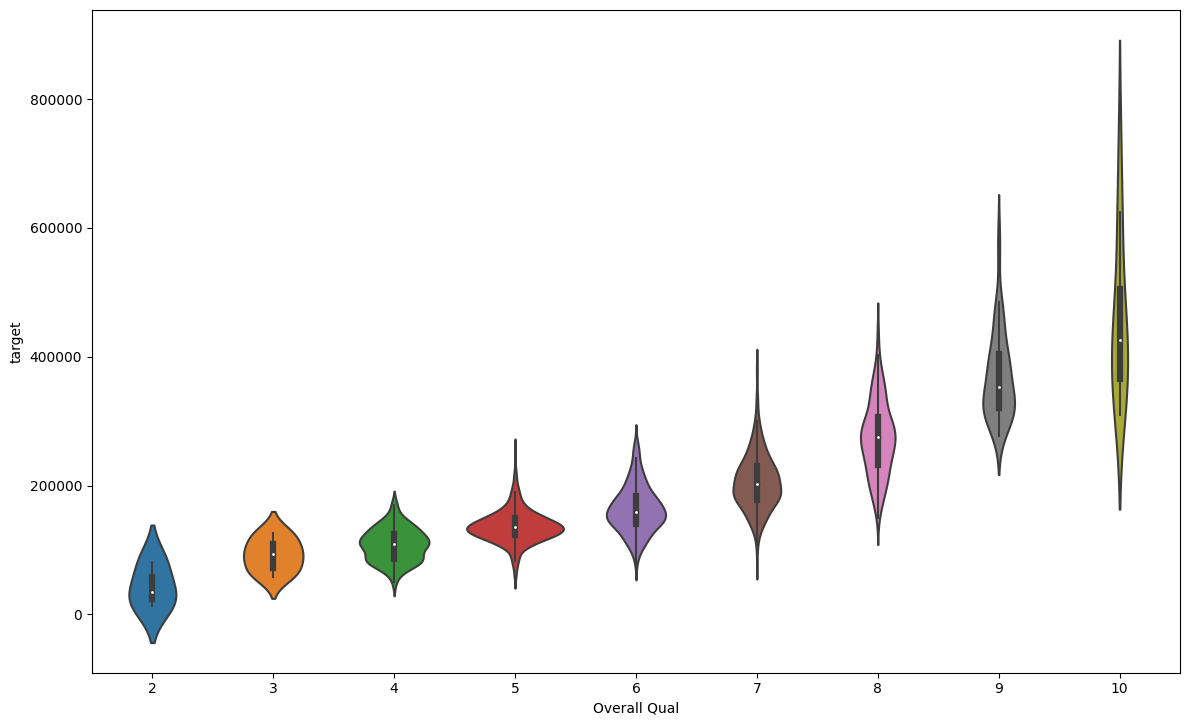

In [12]:
def discrete_plot(variable):
    plt.figure(figsize = (12, 8))
    sns.violinplot(x=train[variable], y=train['target'])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
discrete_plot('Overall Qual')

#### => Overall Qual변수는 재료 품질변수이기 때문에, 이 값이 클수록 집값 분포도 높게 나옴
- 예상결과와 동일하다는 것을 시각화로 확인
- 또한, 변수 값이 커지면 박스 플랏이 길어지며 분사녿 커지는 것을 볼 수 있음
- 표본 개수가 적었던 2, 3 과 10, 4, 9를 병합
- 연속형 변수의 표준화를 위해 평균을 0과 근사하게 하려고 모든 값을 6.5로 빼줌

In [13]:
train['Overall Qual'][train['Overall Qual'] > 9] = 9
train['Overall Qual'][train['Overall Qual'] < 4] = 4
train['Overall Qual']= train['Overall Qual'] - 6.5

In [14]:
test['Overall Qual'][test['Overall Qual'] > 9] = 9
test['Overall Qual'][test['Overall Qual'] < 4] = 4
test['Overall Qual'] = test['Overall Qual'] - 6.5

# Exter Qual 변수
- 외관 재료 품질 : 4등급으로 나뉘어짐
- Fair -> Typical/Average -> Good -> Excellent 

In [15]:
train['Exter Qual'].value_counts()

TA    808
Gd    485
Ex     49
Fa      8
Name: Exter Qual, dtype: int64

In [16]:
test['Exter Qual'].value_counts()

TA    794
Gd    489
Ex     58
Fa      9
Name: Exter Qual, dtype: int64

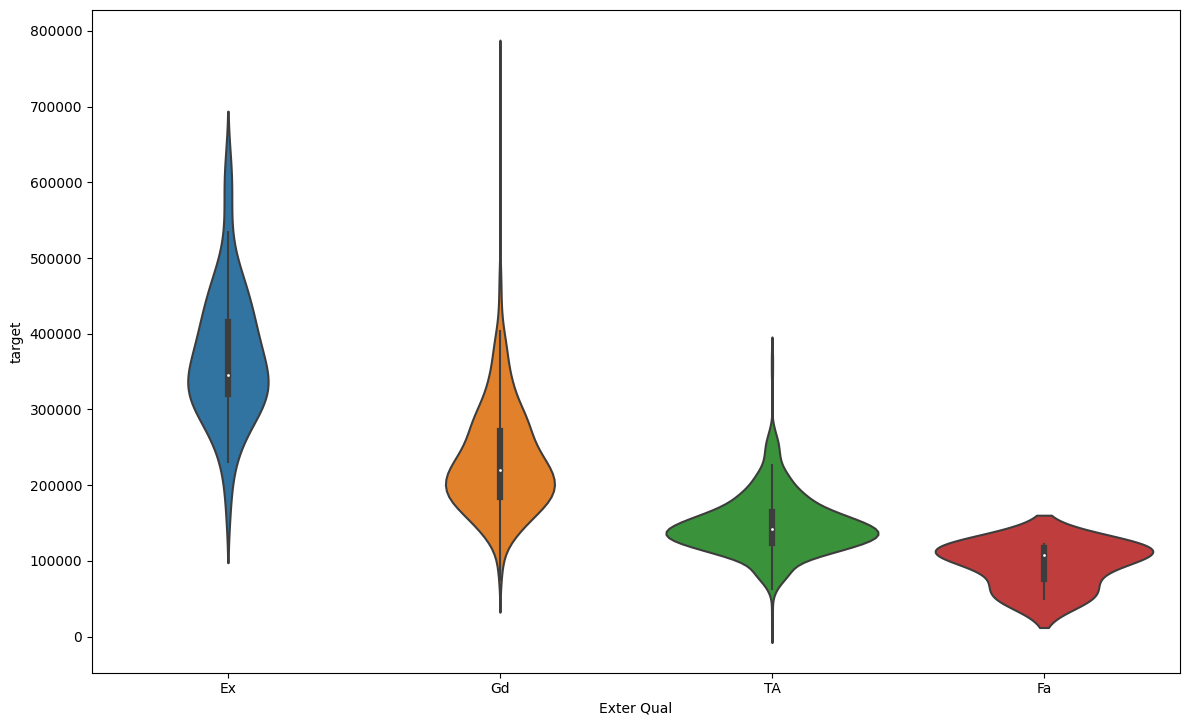

In [17]:
discrete_plot('Exter Qual')

#### => 등급순서대로 집 값이 높음
- Fa 항목 표본이 작았지만 합리적 결과로 보임
- ta, fa 항목에서 큰 차이가 보이지 않아, 항목 개수를 줄여주는 차원에서 두 항목 병합

In [20]:
#추후 연속형 변수들을 표준화 할 예정 => 표준화된 값과 비슷한 형태를 유지하기 위해 값을 1, 0, -1 값을 씀

mapping = {'Ex':1, 'Gd':0, 'TA':-1, 'Fa':-1}

train['Exter Qual'] = train['Exter Qual'].map(mapping)
test['Exter Qual'] = test['Exter Qual'].map(mapping)

In [21]:
train['Exter Qual']

0       1
1       0
2      -1
3      -1
4       0
       ..
1345    0
1346    0
1347   -1
1348   -1
1349   -1
Name: Exter Qual, Length: 1350, dtype: int64

# Garage Cars 변수
- 차고 자리 개수 : 2대가 보편적인 값으로 보임
- 4, 5는 표본 값이 많이 작아 값이 튈 수 있음. (1대, 2애, 3대 이상으로 범주 병합이 좋을것)

In [23]:
train['Garage Cars'].value_counts()

2    794
1    372
3    172
4     11
5      1
Name: Garage Cars, dtype: int64

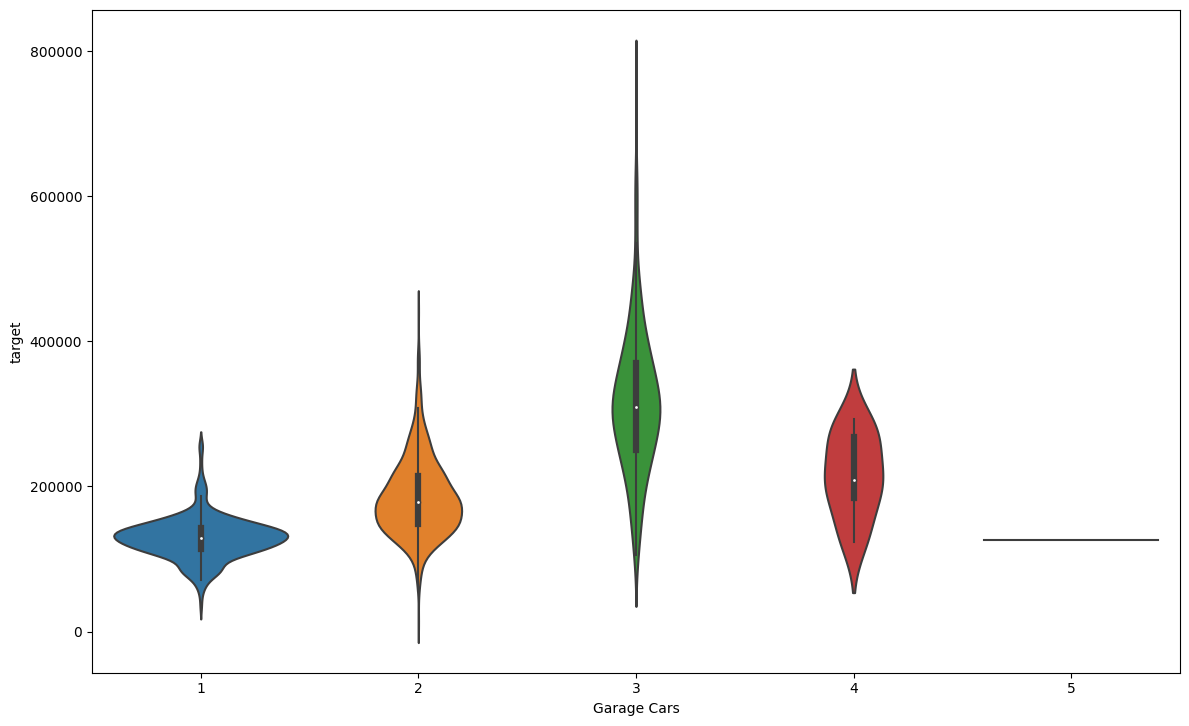

In [24]:
discrete_plot('Garage Cars')

#### => 차고 자리 개수가 많을 수록 더 높은 집값을 가지는 것
- 4, 5 항목은 11, 1개로 작아서 값이 튄걸로 생각하고 3에 포함시킴
- 평균을 0에 근사시키기 위해 전체 값에 2를 빼줌

In [25]:
train['Garage Cars'][train['Garage Cars'] > 3] = 3
train['Garage Cars'] = train['Garage Cars'] - 2

test['Garage Cars'][test['Garage Cars'] > 3] = 3
test['Garage Cars'] = test['Garage Cars'] - 2

# Kitchen Qual 변수
- 부엌 품질변수
- 외관 품질 변수와 항목이 동일하다
- 중간 등급 개수가 많으며, 최하인 fa 등급은 23개로 개수가 많이 낮음
- 테스트 데이터에서 특이하게 po 항목이 있음. fa 보다 낮은 것으로 고려하고 fa와 같은 취급을 할 것

In [26]:
train['Kitchen Qual'].value_counts()

TA    660
Gd    560
Ex    107
Fa     23
Name: Kitchen Qual, dtype: int64

In [27]:
test['Kitchen Qual'].value_counts()

TA    666
Gd    566
Ex     94
Fa     23
Po      1
Name: Kitchen Qual, dtype: int64

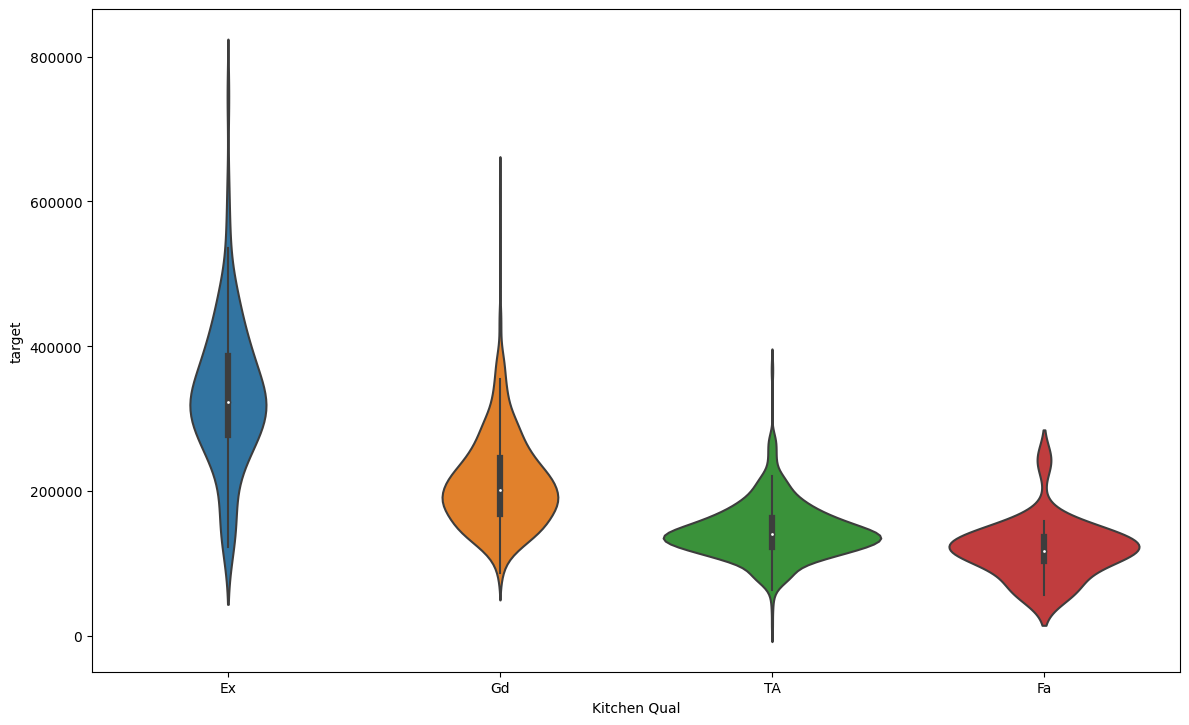

In [28]:
discrete_plot('Kitchen Qual')

#### => Fa 항목의 개수가 23개로 작은 편인데 윗 등급인 TA와 모양에 큰 차이가 없으므로 두 항목을 병합

In [29]:
mapping = {'Ex':1, 'Gd':0, 'TA':-1, 'Fa':-1, 'Po':-1}

train['Kitchen Qual'] = train['Kitchen Qual'].map(mapping)
test['Kitchen Qual'] = test['Kitchen Qual'].map(mapping)

# Bsmt Qual 변수
- 지하실 높이(품질변수와 유사)
- 중간 품질 개수가 많고, fa, po 항목이 많이 적음 => Fa, po는 ta와 병합

In [32]:
train['Bsmt Qual'].value_counts()

TA    605
Gd    582
Ex    134
Fa     28
Po      1
Name: Bsmt Qual, dtype: int64

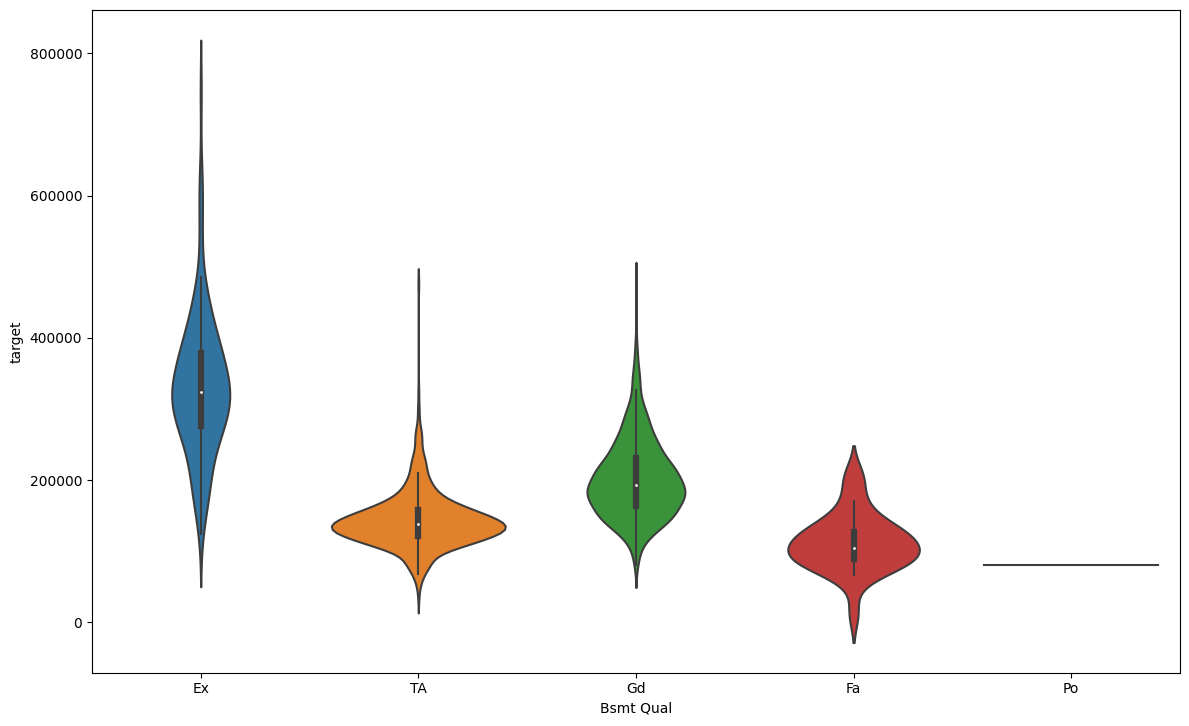

In [33]:
discrete_plot('Bsmt Qual')

In [34]:
mapping={'Ex':1, 'Gd':0, 'TA':-1, 'Fa':-1, 'Po':-1}

train['Bsmt Qual'] = train['Bsmt Qual'].map(mapping)
test['Bsmt Qual'] = test['Bsmt Qual'].map(mapping)

# Full Bath 변수
- 지상층 화장실 개수
- 3개있는 집 27개 -> 꽤 적음. 4개, 0개도 표본이 적음
- 표본이 적은 항목은 병합하는것이 분석에 용이하고 직관성도 올라가므로 병합 고려
- 0 항목은 1 항목과, 2보다 큰 항목은 2 항목과 병합
- 평균을 0에 근사시키기 위해 값을 -1과 1로 

In [35]:
train['Full Bath'].value_counts()

2    703
1    612
3     27
0      6
4      2
Name: Full Bath, dtype: int64

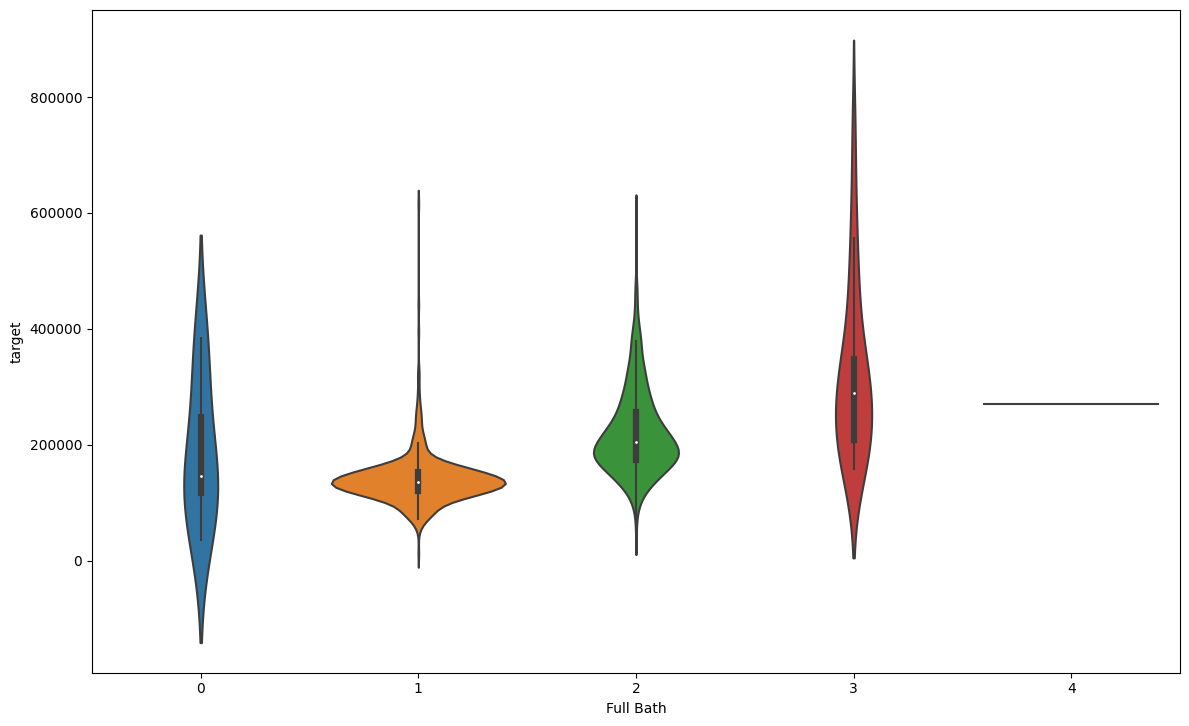

In [37]:
discrete_plot('Full Bath')

In [38]:
train['Full Bath'][train['Full Bath'] <= 1] = -1
train['Full Bath'][train['Full Bath'] >= 2] = 1

test['Full Bath'][test['Full Bath'] <= 1] = -1
test['Full Bath'][test['Full Bath'] >= 2] = 1